In [2]:
import numpy as np
from collections import OrderedDict
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from functools import reduce
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
%config InlineBackend.figure_format = 'retina'
train_on_gpu = torch.cuda.is_available()

c:\Users\keshav\anaconda3\envs\cuda_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#NOTE RESEARCH PAPER IMPLEMENTATION OF DENSE GAN AND RESNET 153 GAN WAS UNABLE TO RUN ON MY SYSTEM SINCE IT WAS TOO HEAVY TO LEAD SO JUMP AHEAD TO IMEPLEMENTATION OF EFFICIENT NET B2 
#IT WORKED OK THOUGH

def DataConstructor2000(path_to_train, path_to_test, classes=None, num_workers=4, batch_size=32, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([224, 224]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [4]:
train_loader, valid_loader,test_loader, classes = DataConstructor2000(path_to_train='E:/STGI/Dataset/train',path_to_test='E:/STGI/Dataset/test',
                                                                       classes=['FAKE','REAL'],num_workers=0, batch_size=100, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


(100, 3, 224, 224)


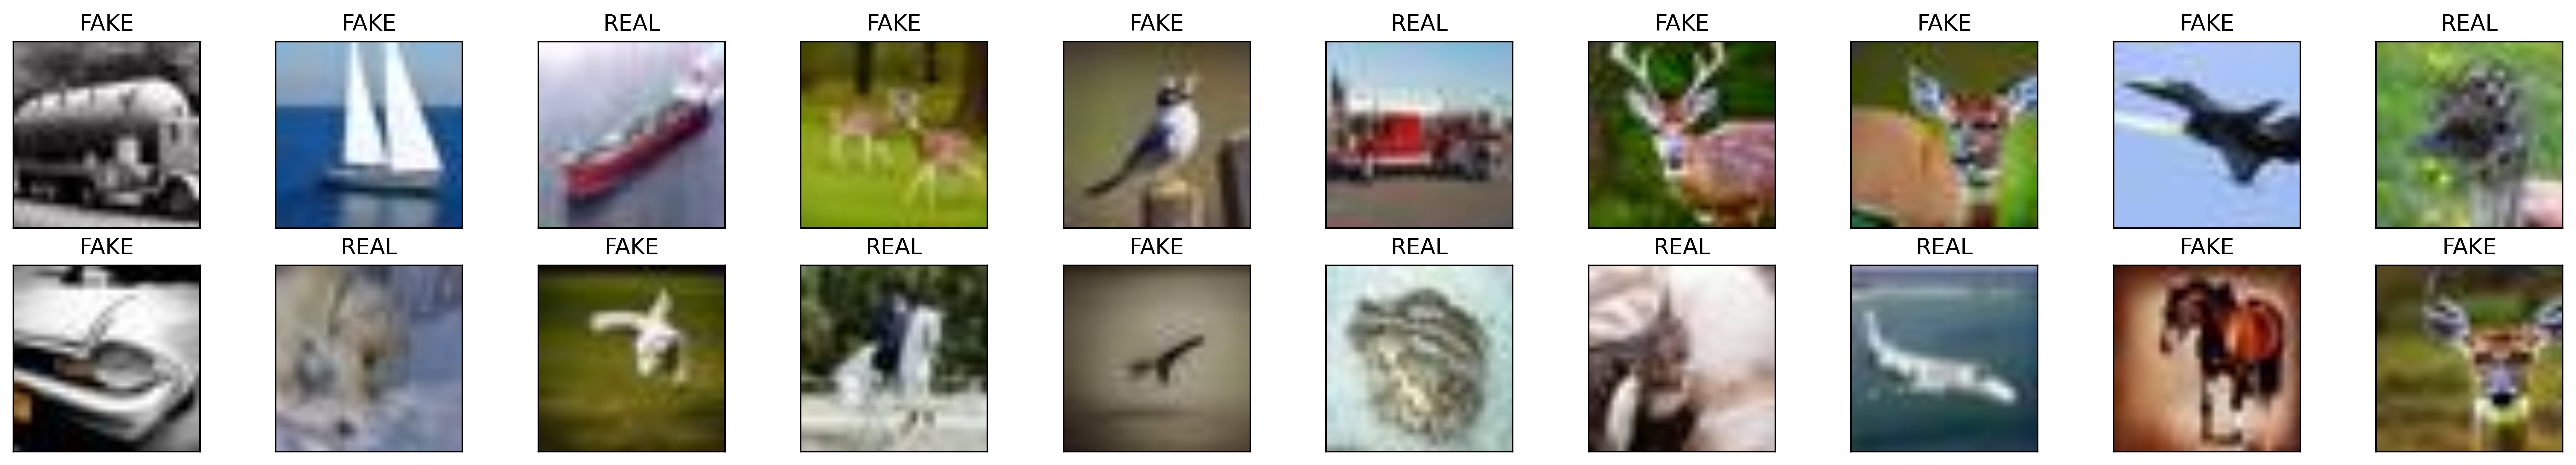

In [5]:
def imshow(img):
#     img = img / 2 + 0.5  # unnormalize if you added normalization in the transformation step
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
# dataiter = iter(train_loader)
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.cpu().numpy()
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=True)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class FBResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        super(FBResNet, self).__init__()
        # Modules
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def features(self, input):
        x = self.conv1(input)
        self.conv1_input = x.clone()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, features):
        x = self.avgpool(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def fbresnet18(num_classes=1000):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = FBResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    return model


def fbresnet34(num_classes=1000):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = FBResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)
    return model


def fbresnet50(num_classes=1000):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = FBResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
    return model


def fbresnet101(num_classes=1000):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = FBResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)
    return model


def fbresnet152(num_classes=2):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = FBResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)

    return model

In [7]:
device = torch.device("cuda")
model = fbresnet152(num_classes=2)
model = nn.DataParallel(model)
# mode

In [8]:
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])

In [9]:
n_epochs = 1

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'ResNet35656_gan-detector_after82.pt')
        valid_loss_min = valid_loss

In [10]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out
class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3
        if bottleneck:
            nDenseBlocks //= 2

        nChannels = 2*growthRate
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        out = F.log_softmax(self.fc(out))
        return out


In [14]:
model = DenseNet(growthRate=12, depth=100, reduction=0.5,
bottleneck=True, nClasses=2)
model = nn.DataParallel(model)
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])



In [15]:
n_epochs = 1

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'DenseNet35656_gan-detector_Final.pt')
        valid_loss_min = valid_loss

: 

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import keras
import os
import numpy as np
# import kaggle
import zipfile
import torch

In [2]:
print(torch.cuda.is_available())
print(tf.test.gpu_device_name())


False



In [13]:
TRAIN_PATH = "E:/STGI/Dataset/train"
TEST_PATH = "E:/STGI/Dataset/train"
IMG_ROWS, IMG_COLS = 32,32
LABELS = ['REAL', 'FAKE']

In [20]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Define constants
MAX_IMAGES = 1000  # Maximum number of images per category

# Initialize lists to store images and labels
REAL_IMAGE = []
REAL_Y = []
FAKE_IMAGE = []
FAKE_Y = []
TEST_REAL_IMAGE = []
TEST_REAL_Y = []
TEST_FAKE_IMAGE = []
TEST_FAKE_Y = []

# Define class labels (Adjust based on your dataset)
classes = {0: 'REAL', 1: 'FAKE'}

# Function to load images from a directory with a maximum limit
def load_images_from_directory(directory, label, max_images=1000, shuffle_files=True, target_size=(224, 224)):
    images = []
    labels = []
    
    # Get a list of all files in the directory
    all_files = os.listdir(directory)
    
    # Filter out non-image files
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    all_files = [f for f in all_files if f.lower().endswith(valid_extensions)]
    
    # Shuffle the list to ensure random selection
    if shuffle_files:
        random.shuffle(all_files)
    
    # Select only the first `max_images` files
    selected_files = all_files[:max_images]
    
    for filename in selected_files:
        img_path = os.path.join(directory, filename)
        try:
            # Load the image with the specified target size
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            # Convert the image to a numpy array
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    return images, labels

# Function to load dataset (TRAIN or TEST)
def load_dataset(base_path, category, label, max_images=1000):
    """
    Loads images for a specific category from the base path.

    Args:
        base_path (str): Base directory path (TRAIN_PATH or TEST_PATH).
        category (str): Subdirectory name ('REAL' or 'FAKE').
        label (int): Label to assign to the images (0 for REAL, 1 for FAKE).
        max_images (int, optional): Maximum number of images to load. Defaults to 1000.

    Returns:
        list: List of image arrays.
        list: List of labels corresponding to the images.
    """
    directory = os.path.join(base_path, category)
    images, labels = load_images_from_directory(
        directory=directory,
        label=label,
        max_images=max_images,
        shuffle_files=True,
        target_size=(IMG_ROWS, IMG_COLS)
    )
    return images, labels

# Load Training Data
print("Loading Training Data...")
REAL_IMAGE, REAL_Y = load_dataset(TRAIN_PATH, 'REAL', label=0, max_images=MAX_IMAGES)
FAKE_IMAGE, FAKE_Y = load_dataset(TRAIN_PATH, 'FAKE', label=1, max_images=MAX_IMAGES)
print(f"Number of REAL training images loaded: {len(REAL_IMAGE)}")
print(f"Number of FAKE training images loaded: {len(FAKE_IMAGE)}")

# Combine Training Data
TRAIN_IMAGES = np.array(REAL_IMAGE + FAKE_IMAGE)
TRAIN_LABELS = np.array(REAL_Y + FAKE_Y)

print(f"Total training images: {TRAIN_IMAGES.shape[0]}")
print(f"Total training labels: {TRAIN_LABELS.shape[0]}")

# Shuffle Training Data
TRAIN_IMAGES, TRAIN_LABELS = shuffle(TRAIN_IMAGES, TRAIN_LABELS, random_state=42)

# Normalize Training Images
TRAIN_IMAGES = TRAIN_IMAGES / 255.0  # Adjust based on your preprocessing

# Load Testing Data
print("\nLoading Testing Data...")
TEST_REAL_IMAGE, TEST_REAL_Y = load_dataset(TEST_PATH, 'REAL', label=0, max_images=500)
TEST_FAKE_IMAGE, TEST_FAKE_Y = load_dataset(TEST_PATH, 'FAKE', label=1, max_images=500)
print(f"Number of REAL testing images loaded: {len(TEST_REAL_IMAGE)}")
print(f"Number of FAKE testing images loaded: {len(TEST_FAKE_IMAGE)}")

# Combine Testing Data
TEST_IMAGES = np.array(TEST_REAL_IMAGE + TEST_FAKE_IMAGE)
TEST_LABELS = np.array(TEST_REAL_Y + TEST_FAKE_Y)

print(f"Total testing images: {TEST_IMAGES.shape[0]}")
print(f"Total testing labels: {TEST_LABELS.shape[0]}")

# Shuffle Testing Data
TEST_IMAGES, TEST_LABELS = shuffle(TEST_IMAGES, TEST_LABELS, random_state=42)

# Normalize Testing Images
TEST_IMAGES = TEST_IMAGES / 255.0  # Adjust based on your preprocessing




Loading Training Data...
Number of REAL training images loaded: 1000
Number of FAKE training images loaded: 1000
Total training images: 2000
Total training labels: 2000

Loading Testing Data...
Number of REAL testing images loaded: 500
Number of FAKE testing images loaded: 500
Total testing images: 1000
Total testing labels: 1000


In [22]:
from sklearn.utils import shuffle

# Combine REAL and FAKE images for training
X_train = np.array(REAL_IMAGE + FAKE_IMAGE, dtype=np.float32) / 255.0  # Normalize pixel values
y_train = np.array(REAL_Y + FAKE_Y)

# Combine REAL and FAKE images for testing
X_test = np.array(TEST_REAL_IMAGE + TEST_FAKE_IMAGE, dtype=np.float32) / 255.0  # Normalize pixel values
Y_test = np.array(TEST_REAL_Y + TEST_FAKE_Y)

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of training labels: {y_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")
print(f"Number of testing labels: {Y_test.shape[0]}")

Number of training samples: 2000
Number of training labels: 2000
Number of testing samples: 1000
Number of testing labels: 1000


In [23]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle testing data
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

In [24]:
rawEfficientnet = keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_ROWS,IMG_COLS,3),
    pooling=None,
    classes=2,
    classifier_activation="sigmoid"
)

31790344/31790344 [==============================] - 7s 0us/step


In [25]:
efficientnet = rawEfficientnet
efficientnet.trainable = False
inputs = keras.Input(shape=(32, 32, 3))
x = efficientnet(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
efficientnetB2 = keras.Model(inputs, outputs)

In [26]:
efficientnetB2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

HistoryTransfer = efficientnetB2.fit(x = X_train, y = y_train, batch_size = 32, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
63/63 [==============================] - 29s 170ms/step - loss: 0.6970 - binary_accuracy: 0.5090 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 6s 100ms/step - loss: 0.7011 - binary_accuracy: 0.4960 - val_loss: 0.7014 - val_binary_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 6s 103ms/step - loss: 0.6962 - binary_accuracy: 0.4940 - val_loss: 0.7153 - val_binary_accuracy: 0.5000
Epoch 4/20
63/63 [==============================] - 6s 102ms/step - loss: 0.6994 - binary_accuracy: 0.5125 - val_loss: 0.6915 - val_binary_accuracy: 0.5000
Epoch 5/20
63/63 [==============================] - 6s 100ms/step - loss: 0.6949 - binary_accuracy: 0.5155 - val_loss: 0.6907 - val_binary_accuracy: 0.5350
Epoch 6/20
63/63 [==============================] - 6s 102ms/step - loss: 0.6956 - binary_accuracy: 0.5005 - val_loss: 0.6967 - val_binary_accuracy: 0.5100
Epoch 7/20
63/63 [==============================] - 6s 102ms/st

In [27]:
print(f"Loss:Accuracy = {efficientnetB2.evaluate(X_test, Y_test)}")

y_pred = efficientnetB2.predict(X_test)
y_pred = np.array(y_pred)

print(classification_report(Y_test, y_pred.round()))
print(f1_score(Y_test, y_pred.round()))
print(recall_score(Y_test, y_pred.round()))
print(precision_score(Y_test, y_pred.round()))

32/32 [==============================] - 2s 70ms/step - loss: 0.6933 - binary_accuracy: 0.5180
Loss:Accuracy = [0.6932670474052429, 0.5180000066757202]
32/32 [==============================] - 6s 66ms/step
              precision    recall  f1-score   support

           0       0.51      0.92      0.66       500
           1       0.59      0.12      0.19       500

    accuracy                           0.52      1000
   macro avg       0.55      0.52      0.43      1000
weighted avg       0.55      0.52      0.43      1000

0.19397993311036793
0.116
0.5918367346938775


In [28]:
efficientnet.trainable = True
efficientnetB2.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

HistoryTransfer = efficientnetB2.fit(x = X_train, y = y_train, batch_size = 32, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
63/63 [==============================] - 75s 338ms/step - loss: 0.6981 - binary_accuracy: 0.5060 - val_loss: 0.6908 - val_binary_accuracy: 0.5500
Epoch 2/20
63/63 [==============================] - 17s 267ms/step - loss: 0.6854 - binary_accuracy: 0.5625 - val_loss: 0.6795 - val_binary_accuracy: 0.5710
Epoch 3/20
63/63 [==============================] - 17s 265ms/step - loss: 0.6851 - binary_accuracy: 0.5530 - val_loss: 0.6765 - val_binary_accuracy: 0.5810
Epoch 4/20
63/63 [==============================] - 17s 263ms/step - loss: 0.6836 - binary_accuracy: 0.5555 - val_loss: 0.6749 - val_binary_accuracy: 0.5870
Epoch 5/20
63/63 [==============================] - 16s 260ms/step - loss: 0.6778 - binary_accuracy: 0.5775 - val_loss: 0.6706 - val_binary_accuracy: 0.5980
Epoch 6/20
63/63 [==============================] - 16s 256ms/step - loss: 0.6716 - binary_accuracy: 0.5945 - val_loss: 0.6676 - val_binary_accuracy: 0.6000
Epoch 7/20
63/63 [==============================] - 16s 25

In [29]:
print(f"Loss:Accuracy = {efficientnetB2.evaluate(X_test, Y_test)}")

y_pred = efficientnetB2.predict(X_test)
y_pred = np.array(y_pred)

print(classification_report(Y_test, y_pred.round()))
print(f1_score(Y_test, y_pred.round()))
print(recall_score(Y_test, y_pred.round()))
print(precision_score(Y_test, y_pred.round()))

32/32 [==============================] - 2s 74ms/step - loss: 0.6194 - binary_accuracy: 0.6600
Loss:Accuracy = [0.6194029450416565, 0.6600000262260437]
32/32 [==============================] - 6s 71ms/step
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       500
           1       0.67      0.63      0.65       500

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000

0.6480331262939958
0.626
0.6716738197424893
